# Классификация и MSE

Что произойдет если в задаче классификации при обучении применить MSE? вместо возни с log_loss, hinge_loss и прочим

In [4]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [6]:
random_state = 73
x, y = make_classification(1_000, 7, random_state = random_state)
test_size = 0.3
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state)

In [7]:
sgd = sgd_lecture_linear(rng)
sgd.fit(x_train, y_train)
preds = sgd.predict_proba(x_test)
print(f'{roc_auc_score(y_test, preds):.3f}')

0.978


Очень неплохо!

Сравним с Logistic Regression из sklearn (обучается на logloss)

In [8]:
lr = LogisticRegression(random_state = random_state)
lr.fit(x_train, y_train)
lr_preds = lr.predict_proba(x_test)[:, 1]
print(f'{roc_auc_score(y_test, lr_preds):.3f}')

0.981


Не сказать чтобы прямо сильно отличаются качеством!

Как же так? Мы же оптимизировали MSE -- а он для задач регресии!

Попробуем сломать!

Давайте заменим таргеты на -1 и 1 вместо 0 и 1

In [9]:
sgd = sgd_lecture_linear(rng)
sgd.fit(x_train, 2 * y_train - 1)
preds = sgd.predict_proba(x_test)
print(f'{roc_auc_score(2 * y_test - 1, preds):.3f}')

lr = LogisticRegression(random_state = random_state)
lr.fit(x_train, 2 * y_train - 1)
lr_preds = lr.predict_proba(x_test)[:, 1]
print(f'{roc_auc_score(2 * y_test - 1, lr_preds):.3f}')

0.977
0.981


Не сработало!

**Задание**       
А если заменить 0 и 1 на -10 и 10?



1.   Метрики изменятся
#**2.   Метрики не изменятся**
Ответ 2



In [11]:
sgd = sgd_lecture_linear(rng)
sgd.fit(x_train, 20 * y_train - 10)
preds = sgd.predict_proba(x_test)
print(f'{roc_auc_score(y_test, preds):.3f}')

lr = LogisticRegression(random_state=random_state)
lr.fit(x_train, 20 * y_train - 10)
lr_preds = lr.predict_proba(x_test)[:, 1]
print(f'{roc_auc_score(y_test, lr_preds):.3f}')

0.978
0.981


## То есть MSE вполне можно применять для классификации?

В целом да!     
Но мы потеряем некоторые хорошие свойства.     
Вспомним семинар -- оптимизация log_loss эквивалента максимизации правдоподобия, то есть получившиеся оценки это оценки вероятности

Что же нам напредсказывал SGD с MSE?

<Axes: >

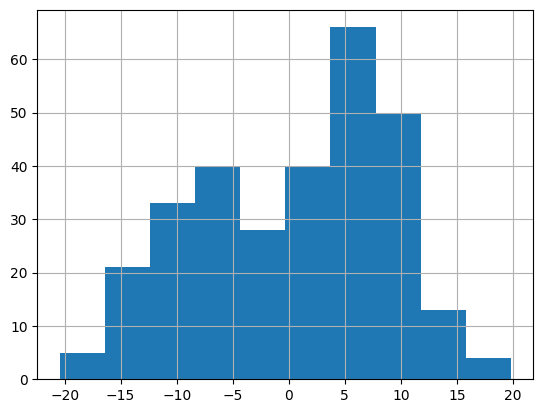

In [12]:
import pandas as pd
pd.Series(preds).hist()

Сравните с предсказаниями логистической регресии

<Axes: >

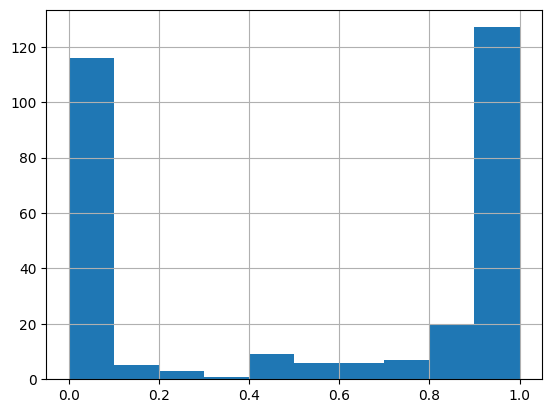

In [13]:
pd.Series(lr_preds).hist()

То есть если логистическая регрессия предсказала, например, 0.9 -- в 9 случаях из 10 целевое событие произойдет

Это свойство логситической регрессии используется в моделях отклика в прайсинге, в оценке вероятности дефолта в рисках и пр.

Так что же, MSE вообще в классификации не использовать?

In [14]:
from sklearn.calibration import calibration_curve, CalibrationDisplay

Для начала посмотрим на калибровочные кривые наших классификаторов

Они строятся так:
1.   Бьем пространство предсказаний на равные бины -- например, точки со скором от 0 до 0.2, от 0.2 до 0.4 и пр
2.   В каждом таком бине считаем средний скор (среднее значение всех предсказание, попавши в бин) -- это горизонтальная координата
3.   В каждом бине считаем долю единичек -- это вертикальная координата
4.   Получившиеся точки соединяем ломаной

При идеальной калибровке средний скор будет совпадать с концентрацией риска

Посмотрим как откалибрована логистическая регрессия

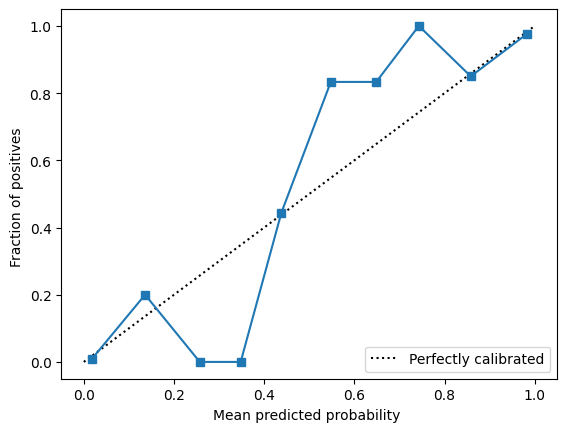

In [ ]:
prob_true, prob_pred = calibration_curve(y_test, lr_preds, n_bins=10)
disp = CalibrationDisplay(prob_true, prob_pred, lr_preds)
disp.plot()

Почему так получилось?

Смотрим на предыдущую картинку с распределением предиктов -- очень мало наблюдений попало в середину

Теперь как калиброван наш SGD с MSE, предварительно шкалируем предикты

In [15]:
preds = (preds - min(preds)) / max(preds - min(preds))

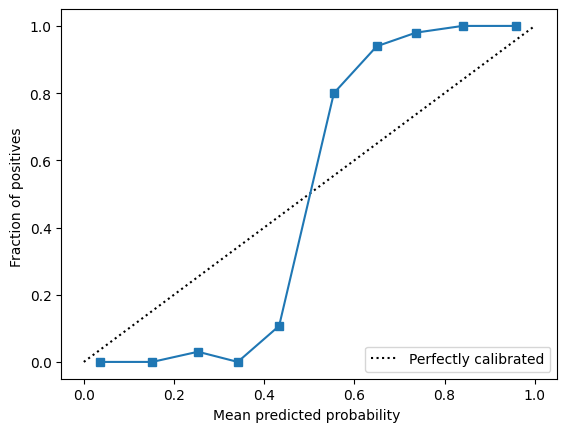

In [16]:
prob_true, prob_pred = calibration_curve(y_test, preds, n_bins=10)
disp = CalibrationDisplay(prob_true, prob_pred, preds)
disp.plot()

Да уж! Вот здесь точно нельзя использовать предикты как вероятность!

Но это на глаз,  а как же количественно сравнить эти две кривые?

Для этого используется специальная метрика**:

$$
\text{Brier Score} = \frac{1}{N} \sum_{i=1}^{N} \left( y_i - p_i \right)^2
$$

** это вариант sklearn, в рисках применяется после разделения на 3 части -- аналогично разделению MSE на bias и variance -- мы еще поговорим об этом в семинаре по ансамблям

**Задание**:

Какой известный лосс вам напомнила эта формула

1.   huber loss
#2.   MSE
3.   MSLE
4.   hinge loss
5.   log loss
6.   triplet loss

Ответ 2


**Задание**:
В нашем примере как отличается Brier Score у логистической регрессии (LR) и SGD c MSE?

 1.   У LR в три и более раз выше
2.   У LR выше от двух до трех раз
3.   Различия несущественны,  составляют не более 10%
#4.   У LR ниже от двух до трех раз
5.   У LR в три и более раз ниже

Ответ 4

Model                  Brier Score
-------------------  -------------
Logistic Regression         0.1194
SGD with MSE                0.2177
Ratio (LR/SGD)              0.55
Разница                    -0.0983

ВЫВОД: Различия составляют 45.2%


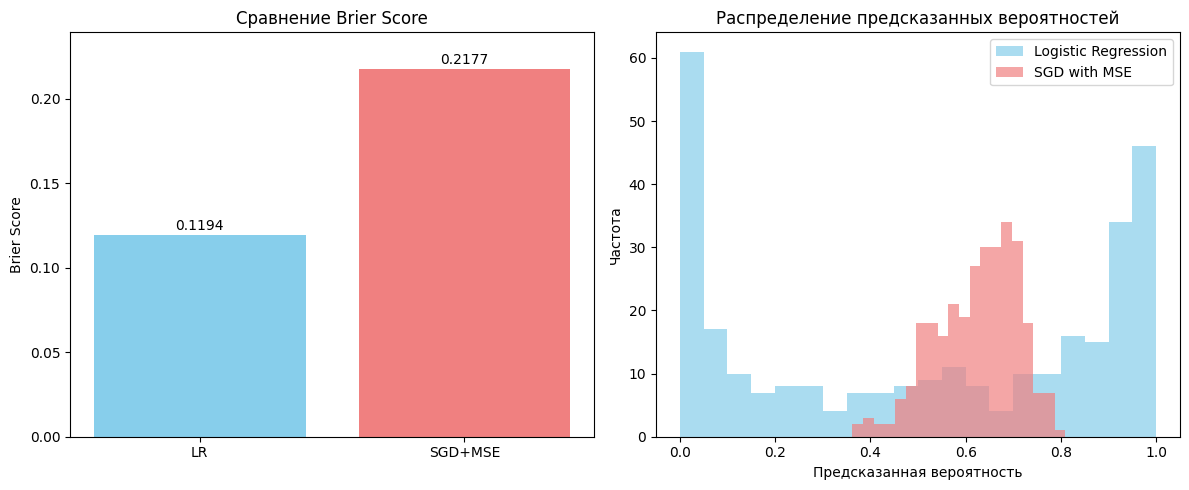

LR Brier Score: 0.1194
SGD MSE Brier Score: 0.2177
Отношение LR/SGD: 0.55
Разница: -0.0983


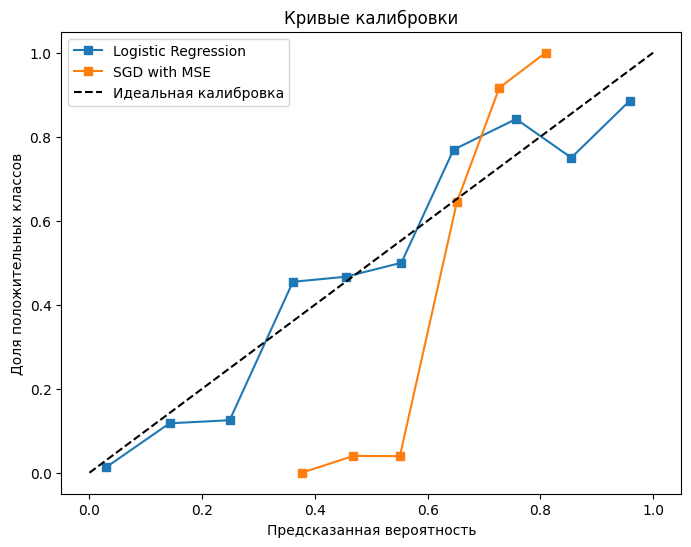

In [17]:
from sklearn.metrics import brier_score_loss, mean_squared_error
from tabulate import tabulate
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt


X, y = make_classification(n_samples=1000, n_features=20, n_redundant=2,
                          n_informative=10, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)

sgd = sgd_lecture_linear(rng)
sgd.fit(X_train, y_train, loss='MSE')

lr_probs = lr.predict_proba(X_test)[:, 1]
sgd_raw_preds = sgd.predict_proba(X_test)

sgd_probs = 1 / (1 + np.exp(-np.array(sgd_raw_preds)))

lr_brier = brier_score_loss(y_test, lr_probs)
sgd_brier = brier_score_loss(y_test, sgd_probs)

ratio = lr_brier / sgd_brier

results = [
    ["Logistic Regression", f"{lr_brier:.4f}"],
    ["SGD with MSE", f"{sgd_brier:.4f}"],
    ["Ratio (LR/SGD)", f"{ratio:.2f}"],
    ["Разница", f"{(lr_brier - sgd_brier):.4f}"]
]

print(tabulate(results, headers=["Model", "Brier Score"]))
print("\n" + "="*50)

if ratio >= 3:
    conclusion = "У LR в три и более раз ВЫШЕ"
elif ratio >= 2:
    conclusion = "У LR выше от двух до трех раз"
elif ratio <= 0.33:
    conclusion = "У LR в три и более раз НИЖЕ"
elif ratio <= 0.5:
    conclusion = "У LR ниже от двух до трех раз"
elif abs(1 - ratio) <= 0.1:
    conclusion = "Различия несущественны, составляют не более 10%"
else:
    conclusion = f"Различия составляют {abs(1-ratio)*100:.1f}%"

print(f"ВЫВОД: {conclusion}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
models = ['LR', 'SGD+MSE']
scores = [lr_brier, sgd_brier]
bars = plt.bar(models, scores, color=['skyblue', 'lightcoral'])
plt.ylabel('Brier Score')
plt.title('Сравнение Brier Score')
plt.ylim(0, max(scores) * 1.1)
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
             f'{score:.4f}', ha='center', va='bottom')

plt.subplot(1, 2, 2)
plt.hist(lr_probs, bins=20, alpha=0.7, label='Logistic Regression', color='skyblue')
plt.hist(sgd_probs, bins=20, alpha=0.7, label='SGD with MSE', color='lightcoral')
plt.xlabel('Предсказанная вероятность')
plt.ylabel('Частота')
plt.title('Распределение предсказанных вероятностей')
plt.legend()

plt.tight_layout()
plt.show()

print(f"LR Brier Score: {lr_brier:.4f}")
print(f"SGD MSE Brier Score: {sgd_brier:.4f}")
print(f"Отношение LR/SGD: {ratio:.2f}")
print(f"Разница: {lr_brier - sgd_brier:.4f}")

from sklearn.calibration import calibration_curve

fop_lr, mpv_lr = calibration_curve(y_test, lr_probs, n_bins=10)
fop_sgd, mpv_sgd = calibration_curve(y_test, sgd_probs, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(mpv_lr, fop_lr, 's-', label='Logistic Regression')
plt.plot(mpv_sgd, fop_sgd, 's-', label='SGD with MSE')
plt.plot([0, 1], [0, 1], 'k--', label='Идеальная калибровка')
plt.xlabel('Предсказанная вероятность')
plt.ylabel('Доля положительных классов')
plt.title('Кривые калибровки')
plt.legend()
plt.show()